# Przetwarzanie danych

In [1]:
from sklearn.preprocessing import StandardScaler
from skfuzzy.cluster import cmeans, cmeans_predict
from sklearn.metrics import pairwise_distances_argmin_min


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
import math
import sys

### Parametry startowe programu

In [2]:
chunk_length_train = 200
chunk_length_test = 50
std_div = 0
n_clusters = 10
n_classes = 4
dim = 6
injection = 0.0
m = 2
g_error = 0.05
stratify_percantage = 1.0
dataset_name = 'BasicMotions'
visualise_processed_data = False
visualise_non_incremental_data = False
visualise_incremental_data = False

## Dane

In [3]:
%cd ..

D:\FuzzyC\FuzzyClusteringAlgorithms


In [ ]:
from libraries.tests.test_dataset import test_dataset

test_dataset(chunk_length_train = chunk_length_train, chunk_length_test = chunk_length_test, std_div = std_div, n_clusters = n_clusters, n_classes = n_classes, dim = dim, injection = injection, m = m, error = g_error, stratify_percantage = stratify_percantage, dataset_name = dataset_name, visualise_processed_data = visualise_processed_data, visualise_non_incremental_data = visualise_non_incremental_data, visualise_incremental_data = visualise_incremental_data)

  Algorytm biblioteczny FCM
Czas wykonania: 0.9199068546295166 sekund
  Własna implementacja FCM
Czas wykonania: 0.6720004081726074 sekund
  Algorytm SSFCM
Czas wykonania: 0.6100001335144043 sekund
  KNN   k = 7
Czas wykonania: 0.9770026206970215 sekund
  KNN z 40% danymi treningowymi, k = 7
Czas wykonania: 0.9619991779327393 sekund
  RocketClassifier


### Pobieranie danych z bibliotek

In [4]:
from tslearn.datasets import UCR_UEA_datasets
from libraries.process_data import convert_to_dataframe, reshape_data

# Inicjalizacja obiektu odpowiedzialnego za zbiory danych
ucr_uea = UCR_UEA_datasets()

# Pobieranie zbioru danych 'AbnormalHeartbeat'
#X_train_heartbeat, y_train_heartbeat, X_test_heartbeat, y_test_heartbeat = ucr_uea.load_dataset('AbnormalHeartbeat')

# Pobieranie zbioru danych 'BasicMotions'
#X_train_motions, y_train_motions, X_test_motions, y_test_motions = ucr_uea.load_dataset('BasicMotions')

# Pobieranie zbioru danych 'ACSF1'
#X_train_ASCF, y_train_ASCF, X_test_ASCF, y_test_ASCF = ucr_uea.load_dataset('ACSF1')

# Pobieranie zbioru danych 'PhonemeSpectra'
#X_train_PhonemeSpectra, y_train_PhonemeSpectra, X_test_PhonemeSpectra, y_test_PhonemeSpectra = ucr_uea.load_dataset('PhonemeSpectra')

# Pobieranie zbioru danych 'EigenWorms'
#X_train_EigenWorms, y_train_EigenWorms, X_test_EigenWorms, y_test_EigenWorms = ucr_uea.load_dataset('EigenWorms')

## Basic Motions
#X_train, y_train = convert_to_dataframe(X_train_motions, y_train_motions)
#X_test, y_test = convert_to_dataframe(X_test_motions, y_test_motions)
#
## HeartBeat
#X_train, y_train = convert_to_dataframe(X_train_heartbeat, y_train_heartbeat)
#X_test, y_test = convert_to_dataframe(X_test_heartbeat, y_test_heartbeat)
#
## ACSF1
#X_train, y_train = convert_to_dataframe(X_train_ASCF, y_train_ASCF)
#X_test, y_test = convert_to_dataframe(X_test_ASCF, y_test_ASCF)
#
## PhonemeSpectra
#X_train, y_train = convert_to_dataframe(X_train_PhonemeSpectra, y_train_PhonemeSpectra)
#X_test, y_test = convert_to_dataframe(X_test_PhonemeSpectra, y_test_PhonemeSpectra)

# EigenWorms
#X_train, y_train = convert_to_dataframe(X_train_EigenWorms, y_train_EigenWorms)
#X_test, y_test = convert_to_dataframe(X_test_EigenWorms, y_test_EigenWorms)


In [5]:
# Pobieranie zbioru danych 'EigenWorms'
X_train_, y_train_, X_test_, y_test_ = ucr_uea.load_dataset(dataset_name)

X_train, y_train = convert_to_dataframe(X_train_, y_train_)
X_test, y_test = convert_to_dataframe(X_test_, y_test_)

sample_size = X_train.shape[1]
X_train.shape

(108, 6)

In [6]:
X_train, y_train = reshape_data(X_train, y_train, sample_size)
X_test, y_test = reshape_data(X_test, y_test, sample_size)

### Stratyfikacja

In [7]:
from libraries.process_data import stratify_data

In [8]:
if stratify_percantage < 1.0:
    X_train, y_train = stratify_data(X_train, y_train, stratify_percantage)
    X_test, y_test = stratify_data(X_train, y_train, stratify_percantage)

### Importowanie danych z dysku

In [9]:
from libraries.load import load_dataset_to_dataframe

filepath_train_basicmotions = './datasets/BasicMotions/BasicMotions_TRAIN.arff'
filepath_test_basicmotions = './datasets/BasicMotions/BasicMotions_TEST.arff'

#df_train = load_dataset_to_dataframe(filepath_train_basicmotions)
#df_test = load_dataset_to_dataframe(filepath_test_basicmotions)

In [10]:
def stack_columns(stacked_train):
    result = stacked_train.loc[0,0]
    
    for i in range(1,stacked_train.shape[0]):
        result = np.column_stack((result, stacked_train.loc[i,0]))
    return result

#X_train = stack_columns(stacked_train)
#X_test = stack_columns(stacked_test)

### Mapowanie labeli

In [11]:
# Jeżeli label odnosi sie do odcinka (nie do punktu czasowego) to rozszerz go.
# Jeżeli labele sa stringami, to zamien je na inty (0, 1, 2, ...)
from libraries.process_data import extend_list, map_strings_to_ints

#y_test_extended = extend_list(y_test,  sample_size)
#y_train_extended = extend_list(y_train, sample_size)

In [12]:
# Zamienianie stringów na int
y_train = map_strings_to_ints(y_train)
y_test = map_strings_to_ints(y_test)

In [13]:
print(X_train.shape)
print(np.unique(y_train))

(129276, 6)
[ 0  1  2  3  4  5  6  7  8  9 10 11]


### Genrowanie syntetycznych danych

#### Generowanie danych syntetycznych sinusoidalnych

In [14]:
from libraries.generate_datasets import generate_multidimensional_sine_data, generate_dataset_blobs

# Parametry
num_dimensions = 6  # liczba wymiarów 
frequency = 1  # częstotliwość
amplitude = 1  # amplituda
phase = [0, np.pi/4, np.pi/2, 0, 0, 0]  # fazy początkowe dla każdego wymiaru
duration = 50  # czas trwania sygnału
sampling_rate = 100  # liczba próbek na jednostkę czasu
noise_std = 0.2  # odchylenie standardowe szumu
num_classes = n_clusters

In [15]:
# Generowanie danych
#t_train, X_train, y_train_extended_list = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)
#t_test, X_test, y_test_extended = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)

#### Generowanie plam

In [16]:
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_blobs(n=3000,c=dim,k=n_clusters,seed=42)

#### Generowanie prostych

In [17]:
from libraries.generate_datasets import generate_dataset_lines

# Parametry linii prostych
a_values = [2, 2, 2]  # Współczynniki a dla różnych składowych
b_values = [1, 10, 20]      # Współczynniki b dla różnych składowych
num_points = 5000           # Liczba punktów danych
std_dev = 0.1     # Odchylenie standardowe dla szumu

In [18]:
#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_lines(a_values, b_values, num_points = num_points, std_dev = std_dev, n_clusters = n_clusters)

## Processing danych

### Tasowanie danych

In [19]:
from libraries.process_data import sort_by_class, shuffle_dataset_with_chunk_sizes

In [20]:
# Dziele punkty na segmenty średniej weilkości chunk_length_train z odchyleniem standardowym std_div. Segmenty są jednej klasy
# Następnie tasuje w ten sposób utworzone segmenty
X_train, y_train, chunk_train_sizes = shuffle_dataset_with_chunk_sizes(X_train, y_train, chunk_length_train, std_div)
X_test, y_test, chunk_test_sizes = shuffle_dataset_with_chunk_sizes(X_test, y_test, chunk_length_test, std_div)

### Wizualizacja danych

Dane podzielone i potasowane we wcześniejszym kroku, pokolorowane ze względu na klase

IndexError: index 6 is out of bounds for axis 1 with size 6

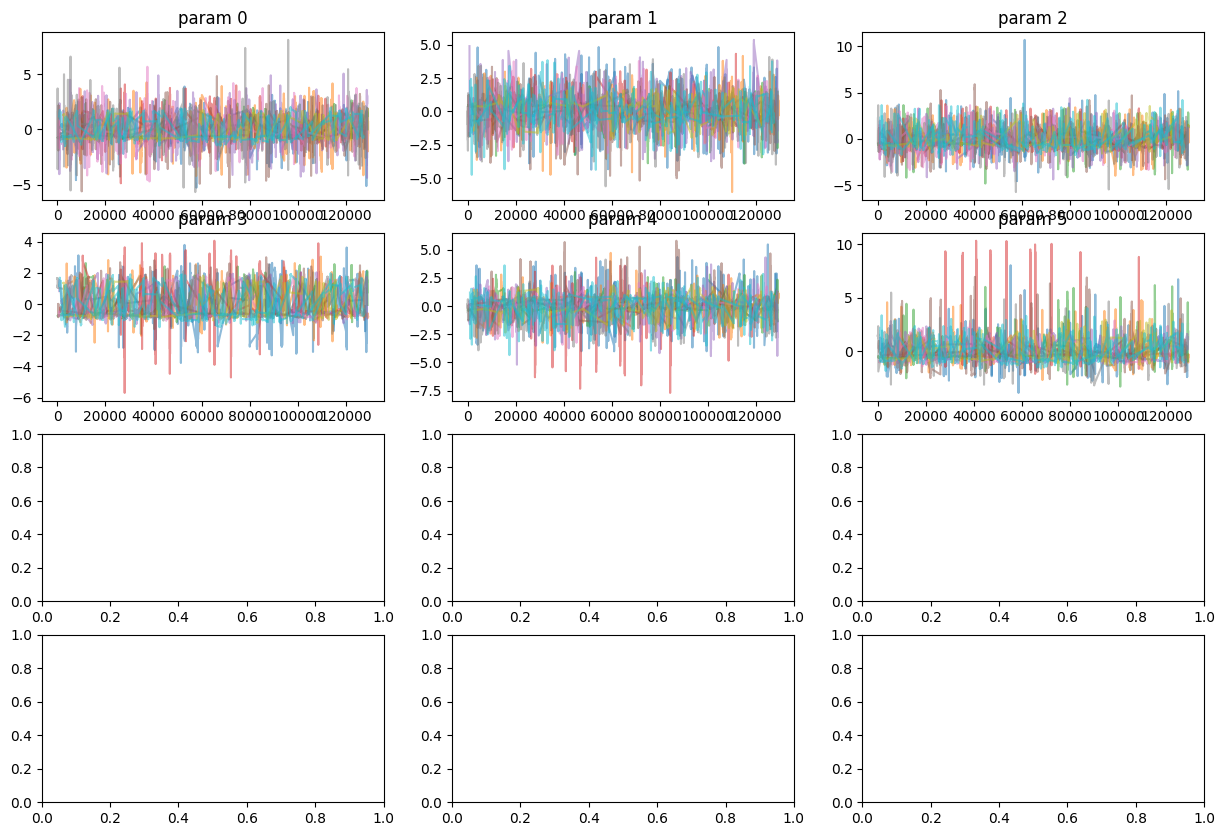

In [21]:
from libraries.plot_functions import visualise_labeled_data_all_dimensions

visualise_labeled_data_all_dimensions(X_train, y_train, n_classes)

### Tasowanie danych


In [ ]:
# Tworzymy chunki z całkowicie potasowanymi danymi. Segmenty posiadają różne elementy z różnych klas
from libraries.process_data import shuffle_dataset

In [ ]:
X_train_shuffled, y_train_shuffled = shuffle_dataset(X_train, y_train)
X_test_shuffled, y_test_shuffled = shuffle_dataset(X_test, y_test)

In [ ]:
# Wizualizacja każdego wymiaru danych z osobna po potasowaniu.
visualise_labeled_data_all_dimensions(X_train_shuffled, y_train_shuffled, n_classes)

### Punkty inicjalizacyjne i macierze semi_supervised

In [ ]:
from libraries.clusters import  average_by_class, generate_clusters_proportional, label_vector_to_semi_supervised_matrix, create_semi_supervised_matrix, upload_semi_supervised_matrix

In [ ]:
# Inicjalizacja centroidów oraz stworzenie y_matrix_label dla odmian algorytmu semi-supervised.
y_train_matrix, init_centroids, clusters_for_each_class = create_semi_supervised_matrix(X_train, y_train, n_clusters)

y_train_matrix_shuffled, init_centroids_shuffled, clusters_for_each_class_shuffled = create_semi_supervised_matrix(X_train_shuffled, y_train_shuffled, n_clusters, injection=injection)

### Tworzenie chunków

In [ ]:
from libraries.chunks import create_chunks, create_dataset_chunks

In [ ]:
# Dzielimy dane oraz labele na chunki długości elementów listy chunk_train_sizes (ew. test)
chunks, chunks_y, chunks_y_matrix = create_dataset_chunks(chunk_train_sizes, X_train, y_train, y_train_matrix)
chunks_test, chunks_test_y, _ = create_dataset_chunks(chunk_test_sizes, X_test, y_test)

In [ ]:
# Dzielimy dane oraz labele na chunki długości elementów listy chunk_train_sizes (ew. test)
chunks_shuffled, chunks_y_shuffled, chunks_y_matrix_shuffled = create_dataset_chunks(chunk_train_sizes, X_train_shuffled, y_train_shuffled, y_train_matrix_shuffled)
chunks_test_shuffled, chunks_test_y_shuffled, _ = create_dataset_chunks(chunk_test_sizes, X_test_shuffled, y_test_shuffled)

In [ ]:
print([len(chunk) for chunk in chunks])

# Metody klastrujące biblioteczne

### KNN

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from libraries.process_data import select_subset, knn_with_library

# Algorytm IFCM

Importowanie funkcji bibliotecznych. Implementacja własna

In [ ]:
from libraries.FCM.IFCM import incremental_fuzzy_cmeans_predict
from libraries.FCM.IFCM import incremental_fuzzy_cmeans

# Algorytm ISSFCM

Importowanie funkcji bibliotecznych. Implementacja własna

In [ ]:
from libraries.FCM.ISSFCM import incremental_semi_supervised_fuzzy_cmeans_predict
from libraries.FCM.ISSFCM import incremental_semi_supervised_fuzzy_cmeans

# Algorytm DISSFCM


In [ ]:
from scipy.spatial.distance import cdist
from libraries.diagnosis_tools import DiagnosisTools, Multilist
from libraries.FCM.DISSFCM import dynamic_incremental_semi_supervised_fuzzy_cmeans_predict
from libraries.FCM.DISSFCM import dynamic_incremental_semi_supervised_fuzzy_cmeans
from libraries.FCM.DISSFCM import reconstruction_error, split_centroids
from libraries.FCM.DISSFCM import dynamic_local_train_incremental_semi_supervised_fuzzy_cmeans
from libraries.FCM.DISSFCM import dynamic_train_incremental_semi_supervised_fuzzy_cmeans

# Metody wizualizacji danych

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import random
from tqdm import tqdm
from libraries.chunks import merge_chunks

### Wizualizacja danych ze zredukowanymi wymiarami

In [ ]:
from libraries.plot_functions import simple_plot, plot_pca, plot_pca_cluster, plot_pca_standard, plot_heatmap, plot_tsne, plot_mds

### Wizualizacja zestawów danych

In [ ]:
from libraries.plot_functions import plot_centroids, plot_two, visualize_all, prepare_diagnosis_data_for_plotting, overview_plot, plot_multiple_functions, plot_lists_inside_lists

# Predykcja i Validacja danych

### Validacja

In [ ]:
from libraries.valid_data import calculate_statistics, most_frequent_in_segments, classify_data_segment
from libraries.valid_data import valid_data_ifcm, valid_data_issfcm, valid_data_dissfcm, valid_data_fcm, valid_data_knn

### Predykcja

In [ ]:
from libraries.FCM.DISSFCM import predict_data_dissfcm
from libraries.FCM.ISSFCM import predict_data_issfcm
from libraries.FCM.IFCM import predict_data_ifcm

# Przypisywanie clustrów do klas

In [ ]:
from libraries.classify_segments import validate_segments, validate_segments_knn

### Zliczanie popularności danych clustrów

In [ ]:
from libraries.clusters import count_points_for_clusters, sum_probability_for_clusters, popularity_of_clusters

### Knn i głosowanie większościowe

In [ ]:
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.spatial.distance import cdist

from collections import Counter
import numpy as np

from libraries.FCM.IFCM import create_labels as create_labels_simple
from scipy import stats

def assign_clusters_to_classes(fuzzy_labels, centroids, y, n_classes):
    # Zliczam pierwsze punkty do jakich klas należą, następnie dopiero patrzę na segmenty.
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    count_points = np.zeros((centroids.shape[0], n_classes))
    
    for i, label in enumerate(cluster_membership):
        count_points[label, y[i]] += 1

    # Zwracamy tablicę z przyporządkowanymi klasami dla każdego clustra.
    return np.argmax(count_points, axis=1)


def assign_class_to_points(fuzzy_labels, cluster_to_class):
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    result = np.zeros(len(cluster_membership), dtype=fuzzy_labels.dtype)

    result[:] = cluster_to_class[cluster_membership]
    return result


def classify_points(trained_x, trained_y, validation_x, validation_y, centroids, metric, m, n_classes, classify_whole_segment = False, validation_x_chunked = None):
    # przynależności wszystkich punktów ze zbioru treningowego do centroidów
    fuzzy_labels_trained = create_labels(trained_x, centroids, metric, m)
    
    # przynależność klastrów do klas
    cluster_to_class = assign_clusters_to_classes(fuzzy_labels_trained, centroids, trained_y, n_classes)
    
    # przynależność wszystkich punktów ze zbioru walidacyjnego do centroidów
    fuzzy_labels_val = create_labels(validation_x, validation_y.T ,centroids, metric, m)

    validation_classified = None
    # wyznaczanie klas na podstawie przynależności do centroidów dla zbioru walidacyjnego
    if classify_whole_segment:
        validation_classified = []

        for chunk in validation_x_chunked:
            fuzzy_labels_chunk = create_labels(chunk, centroids, metric, m)
            chunk_classified = assign_class_to_points(fuzzy_labels_chunk, cluster_to_class)
            mode_value, count = stats.mode(chunk_classified)
            
            validation_classified.append(np.full(chunk_classified.shape, mode_value))
        validation_classified = np.concatenate(validation_classified)  
    else:
        validation_classified = assign_class_to_points(fuzzy_labels_val, cluster_to_class)
    
    return validation_classified
    

def majority_vote_with_elimination(class_vectors, n_classes):
    """
    Przeprowadza głosowanie większościowe z eliminacją najmniej popularnych klas.
    
    Args:
    class_vectors (list of list): Lista wektorów indeksów klas uporządkowanych według przynależności
                                  dla każdego punktu walidacyjnego.
    
    Returns:
    int: Ostateczna wybrana klasa po głosowaniu.
    """
    counter = 0
    #print(class_vectors)
    mark_deletion = np.zeros(n_classes)
    while True:
        # Zliczanie pierwszych klas (najbardziej przynależnych) dla wszystkich punktów
        first_choices = [classes[0] for classes in class_vectors if classes.size > 0]
        class_counter = Counter(first_choices)
        
        # Sprawdzenie, czy mamy jedną dominującą klasę
        if len(class_counter) == 1:
            return first_choices  # Zwróć dominującą klasę
        
        # Znajdź najmniej popularną klasę (lub klasy, jeśli są remisowe)
        min_count = min(class_counter.values())
        least_common_classes = [cls for cls, count in class_counter.items() if count == min_count]

        # Dla każdej klasy do usunięcia
        for cls_to_remove in least_common_classes:
            mark_deletion[cls_to_remove] = 1
            #print("Klasa do usuniecia: ", cls_to_remove)
            # Przejdź przez każdy punkt walidacyjny
            for i, classes in enumerate(class_vectors):
                # Jeśli pierwsza klasa jest tą do usunięcia, usuń ją
                if classes.size > 0 and mark_deletion[classes[0]] == 1:
                    #print("Usuwam: ", classes[0])
                    class_vectors[i] = np.delete(classes, 0)

        # Sprawdź, czy wszystkie wektory klas zostały wyeliminowane
        if all(classes.size == 0 for classes in class_vectors):
            return None  # Zwróć None, jeśli wszystkie klasy zostały wyeliminowane

        if counter >= 4:
            # Zwróć pierwszą klasę, która pozostała na końcu eliminacji
            return first_choices
        
        counter += 1
def classify_with_knn_eliminate_minor(train_matrix, val_matrix, k, prototype_to_class, n_classes):
    """
    Klasyfikuje dane walidacyjne na podstawie k najbliższych sąsiadów z użyciem macierzy przynależności.
    
    Args:
    val_matrix (numpy.ndarray): Macierz przynależności danych walidacyjnych, rozmiar [n_val x K].
    train_matrix (numpy.ndarray): Macierz przynależności danych treningowych, rozmiar [n_train x K].
    k (int): Liczba najbliższych sąsiadów do znalezienia.
    prototype_to_class (list): Lista mapująca każdy prototyp na odpowiednią klasę.
    
    Returns:
    list: Lista sklasyfikowanych klas dla każdej serii czasowej z walidacji.
    """

    n_val = val_matrix.shape[1]
    n_train = train_matrix.shape[1]
    
    classified_labels = []
    
    for i in range(n_val):
        val_series = val_matrix[:, i]
        
        # Oblicz odległość euklidesową między i-tym rzędem w val_matrix a każdym rzędem w train_matrix
        v_expanded = val_series[:, np.newaxis]  # Kształt: (8, 1)

        # Oblicz różnicę pomiędzy punktami a wektorem
        diff = train_matrix - v_expanded
        
        # Oblicz dystans Euklidesowy
        distances = np.sqrt(np.sum(diff**2, axis=0))
        
        # Znajdź indeksy k najmniejszych wartości (najbliższych sąsiadów)
        k_nearest_indices = np.argsort(distances)[:k]
        
        class_to_max_prototype = np.zeros(n_classes)
        
        for idx in k_nearest_indices:
            # Sortuj prototypy według wartości przynależności malejąco dla danego sąsiada
            sorted_prototypes = np.argsort(train_matrix[:, idx])[::-1]
            
            for prototype_idx in sorted_prototypes:
                # Mapuj prototyp na odpowiednią klasę
                mapped_class = prototype_to_class[prototype_idx]
                
                # Jeśli klasa nie była jeszcze dodana lub obecny prototyp ma większą przynależność, zaktualizuj
                if class_to_max_prototype[mapped_class] == 0 or class_to_max_prototype[mapped_class] < train_matrix[prototype_idx, idx]:
                    class_to_max_prototype[mapped_class] = train_matrix[prototype_idx, idx]
                else:
                    break  # Ponieważ sortowanie jest malejące, dalsze prototypy będą miały mniejszą przynależność
        
        sorted_class_indices = np.argsort(class_to_max_prototype)[::-1]       
        # Zlicz klasy k najbliższych sąsiadów
        #class_counter = Counter(k_nearest_classes)
        
        # # Zwróć klasy uporządkowane od najczęstszej do najmniej częstej
        # sorted_classes = [cls for cls, count in class_counter.most_common()]
        #print("sorted_class_indices")
        #print(sorted_class_indices)
        classified_labels.append(sorted_class_indices)
    
    # Przeprowadź głosowanie większościowe z eliminacją
    final_class = majority_vote_with_elimination(classified_labels, n_classes)
    
    return final_class


def classify_points_knn_eliminate_minor_class(chunks, chunks_y, chunks_validation_x, chunks_validation_y, centroids, metric, m, n_classes, classify_whole_segment = False, validation_x_chunked = None, validation_y_chunked = None,  k = 7):
    # przynależności wszystkich punktów ze zbioru treningowego do centroidów
    trained_x, trained_y = merge_chunks(chunks, chunks_y)

    validation_x, validation_y = merge_chunks(chunks_validation_x, chunks_validation_y)
    
    #fuzzy_labels_trained = create_labels(trained_x, trained_y.T, centroids, metric, m)
    _, fuzzy_labels_trained = predict_data_dissfcm(trained_x, centroids)

    # przynależność klastrów do klas
    cluster_to_class = assign_clusters_to_classes(fuzzy_labels_trained, centroids, trained_y, n_classes)

    # przynależność wszystkich punktów ze zbioru walidacyjnego do centroidów
    #fuzzy_labels_val = create_labels_simple(validation_x ,centroids, metric, m)
    fuzzy_labels_val = predict_data_dissfcm(validation_x, centroids)


    validation_classified = None
    validation_classified_chunks_before_voting = []
    validation_classified_chunks_majority = []
    # wyznaczanie klas na podstawie przynależności do centroidów dla zbioru walidacyjnego
    #if classify_whole_segment:
    validation_classified_chunks_majority = []

    itr = 0
    for chunk in validation_x_chunked:
        _, fuzzy_labels_chunk = predict_data_dissfcm(chunk, centroids)
        chunk_classified = classify_with_knn_eliminate_minor(fuzzy_labels_trained, fuzzy_labels_chunk, k, cluster_to_class, n_classes)  
        #print("wynik glosowania")
        #print(chunk_classified)

        mode_value, count = stats.mode(chunk_classified)
            
          
        majority = np.full(len(chunk_classified), mode_value)
            
        validation_classified_chunks_majority.append(majority)
        validation_classified_chunks_before_voting.append(chunk_classified)
            
    validation_classified = np.concatenate(validation_classified_chunks_majority)  
    #validation_classified_chunks_before_voting = np.concatenate(validation_classified_chunks_before_voting)  
    #else:
    #    validation_classified = classify_with_knn(fuzzy_labels_trained, fuzzy_labels_val, k ,cluster_to_class, n_classes)
    return validation_classified, validation_classified_chunks_before_voting, validation_classified_chunks_majority, cluster_to_class , fuzzy_labels_val
    


# Testowanie algorytmu FCM i innych algorytmów bez funkcjonalności inkrementacyjnej

In [ ]:
from libraries.plot_functions import create_set_for_stats, compare_models_statistics

In [ ]:
import time
models = {}
plot_func = plot_pca
metric = 'euclidean'

###########################################################################################################
# Początek pomiaru czasu
start_time = time.time()

# Testowanie bibliotecznego modelu fcm
print('Algorytm biblioteczny FCM')
centroids, fuzzy_labels, u0, d, jm, p, fpc = cmeans(X_train.T, c=n_clusters, m=m, error=g_error, maxiter=1000, init=None)

silhouette_avg, davies_bouldin_avg, rand, fpc, stats, cluster_to_class, fuzzy_labels = valid_data_fcm(chunks_test, centroids, chunks_test_y, m, g_error)

plot_func(X_test, centroids, fuzzy_labels)

models['FCM_library'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, stats)

# Koniec pomiaru czasu
end_time = time.time()

# Wyświetlenie czasu wykonania
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

###########################################################################################################
from libraries.FCM.IFCM import cmeans0

# Początek pomiaru czasu
start_time = time.time()

# Testowanie własnej implementacji fcm
print('Własna implementacja FCM')
centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(X_train, c=n_clusters, m=m, error=g_error, maxiter=1000, metric = metric, init_centroid=None)

silhouette_avg, davies_bouldin_avg, rand, fpc, stats, cluster_to_class, fuzzy_labels = valid_data_ifcm(chunks_test, centroids, chunks_test_y, m, g_error)

plot_func(X_test, centroids, fuzzy_labels)

models['FCM'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, stats)

# Koniec pomiaru czasu
end_time = time.time()

# Wyświetlenie czasu wykonania
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

###########################################################################################################
# Testowanie własnej implementacji semi-supervised fcm

# Początek pomiaru czasu
start_time = time.time()

print('Algorytm SSFCM')
centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_semi_supervised_fuzzy_cmeans(X_train, y_train_matrix, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=None)

silhouette_avg, davies_bouldin_avg, rand, fpc, stats, cluster_to_class, fuzzy_labels = valid_data_issfcm(chunks_test, centroids, chunks_test_y, m, g_error)

plot_func(X_test, centroids, fuzzy_labels)

models['SSFCM'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, stats)

# Koniec pomiaru czasu
end_time = time.time()

# Wyświetlenie czasu wykonania
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

##########################################################################################################
# Testiwabeu knn 

# Scalamy segmenty w jeden dataset    
data_test, y_extended = merge_chunks(chunks_test, chunks_test_y)

# Początek pomiaru czasu
start_time = time.time()

k = 7
print(f'KNN   k = {k}')
knn_model = knn_with_library(X_train, y_train, k)

cluster_membership = knn_model.predict(data_test)

silhouette_avg, davies_bouldin_avg, rand, statistics = valid_data_knn(chunks_test, chunks_test_y, knn_model)

models['KNN'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, statistics)

plot_pca_standard(data_test, cluster_membership)

# Koniec pomiaru czasu
end_time = time.time()

# Wyświetlenie czasu wykonania
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

###########################################################################################################
# Testowanie knn 

# Początek pomiaru czasu
start_time = time.time()

print(f'KNN z 40% danymi treningowymi, k = {k}')

X_train_subset, y_train_subset = select_subset(X_train, y_train, p=0.3)

knn_model_p = knn_with_library(X_train_subset, y_train_subset, k)

cluster_membership = knn_model.predict(data_test)

silhouette_avg, davies_bouldin_avg, rand, statistics = valid_data_knn(chunks_test, chunks_test_y, knn_model_p)

models['KNN p%'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, statistics)

plot_pca_standard(data_test, cluster_membership)

# Koniec pomiaru czasu
end_time = time.time()

# Wyświetlenie czasu wykonania
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

###########################################################################################################
# porównanie wyników
compare_models_statistics(models)

# Testowanie algorytmu DISSFCM

### Trenowanie Local DISSFCM 

In [ ]:
diagnosis_chunk, diagnosis_iterations, best_centroids = dynamic_local_train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, n_classes, chunks, chunks_y, chunks_y_matrix, chunks_test, chunks_test_y, clusters_for_each_class.copy(), injection, m=m, visualise_data=True, init_centroids=init_centroids.copy())

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie DISSFCM

In [ ]:
diagnosis_chunk, diagnosis_iterations, best_centroids = dynamic_train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks_shuffled, chunks_y_shuffled, chunks_y_matrix_shuffled, chunks_test, chunks_test_y, clusters_for_each_class_shuffled.copy(), injection, m=m, visualise_data=True, init_centroids=init_centroids_shuffled.copy())

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

# Testowanie algorytmu IFCM

### Implementacja algorytmów

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output
import time
import sys
import statistics
from libraries.FCM.IFCM import incremental_fuzzy_cmeans
from libraries.FCM.IFCM import train_incremental_local_fuzzy_cmeans
from libraries.FCM.IFCM import train_incremental_fuzzy_cmeans
from libraries.FCM.IFCM import train_incremental_fuzzy_cmeans_extending_data

### Trenowanie Local IFCM

Processing:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

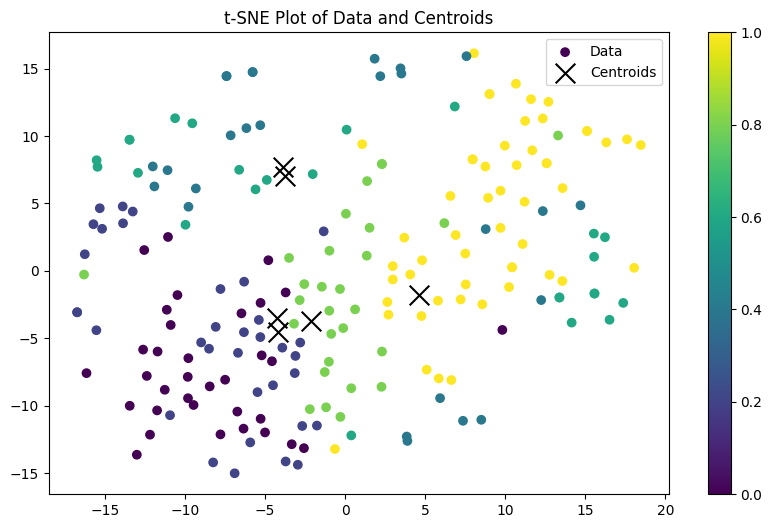

Processing:   5%|███▌                                                                   | 1/20 [00:01<00:28,  1.50s/it]

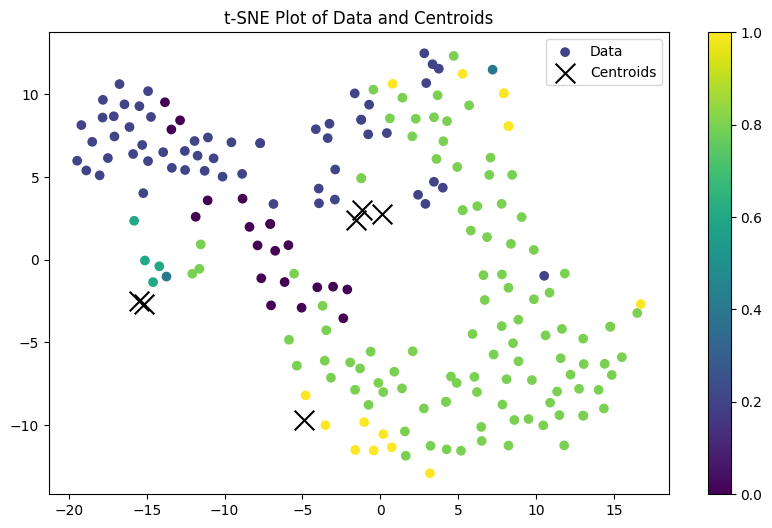

Processing:  10%|███████                                                                | 2/20 [00:02<00:26,  1.47s/it]

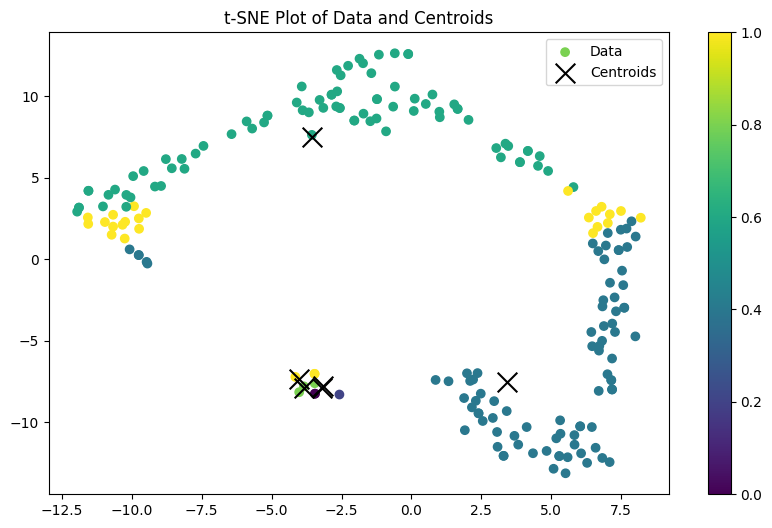

Processing:  15%|██████████▋                                                            | 3/20 [00:04<00:23,  1.39s/it]

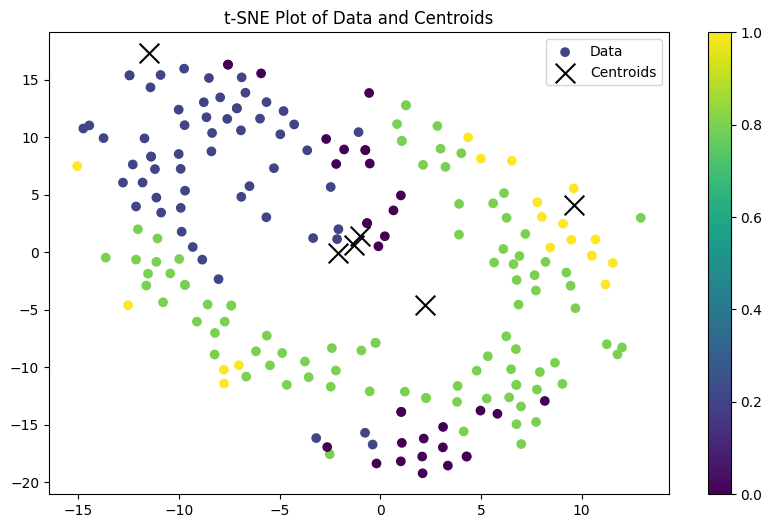

Processing:  20%|██████████████▏                                                        | 4/20 [00:05<00:21,  1.33s/it]

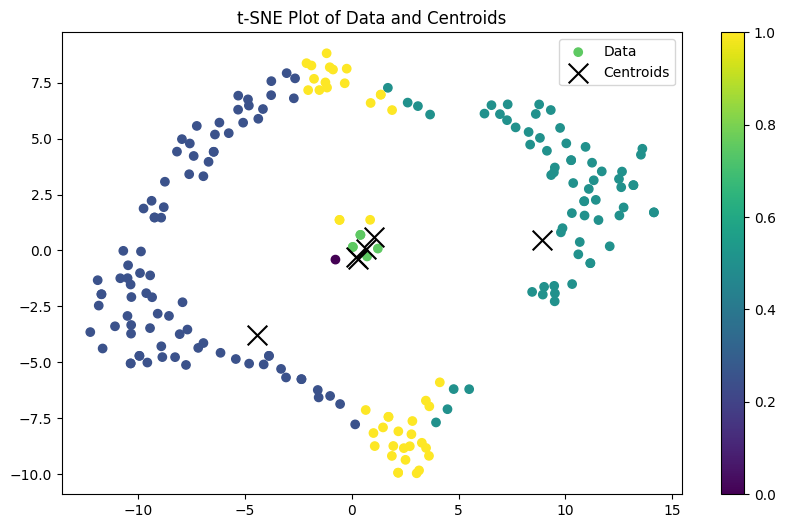

Processing:  25%|█████████████████▊                                                     | 5/20 [00:06<00:19,  1.29s/it]

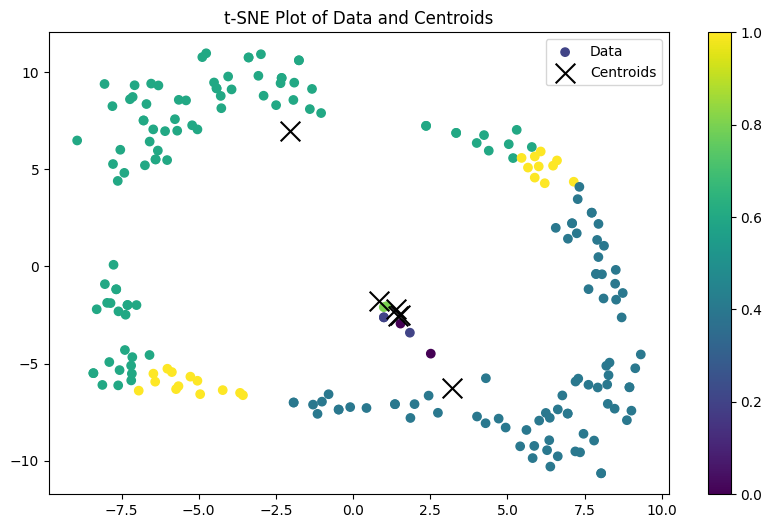

Processing:  30%|█████████████████████▎                                                 | 6/20 [00:07<00:17,  1.25s/it]

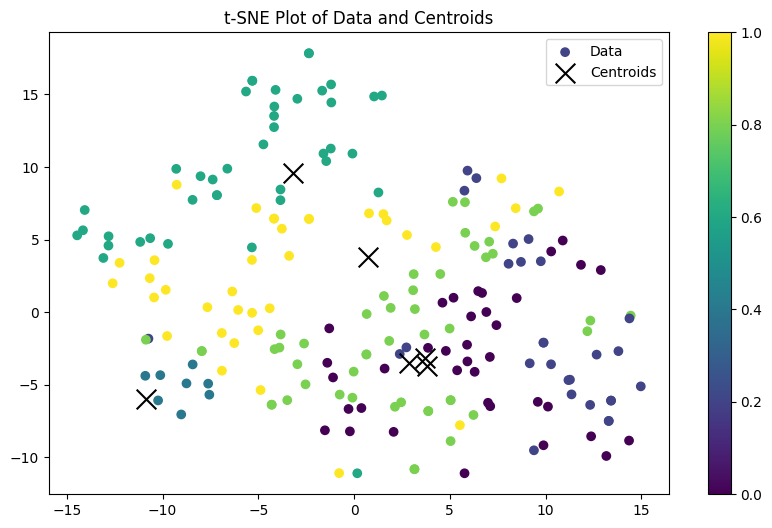

Processing:  35%|████████████████████████▊                                              | 7/20 [00:09<00:16,  1.25s/it]

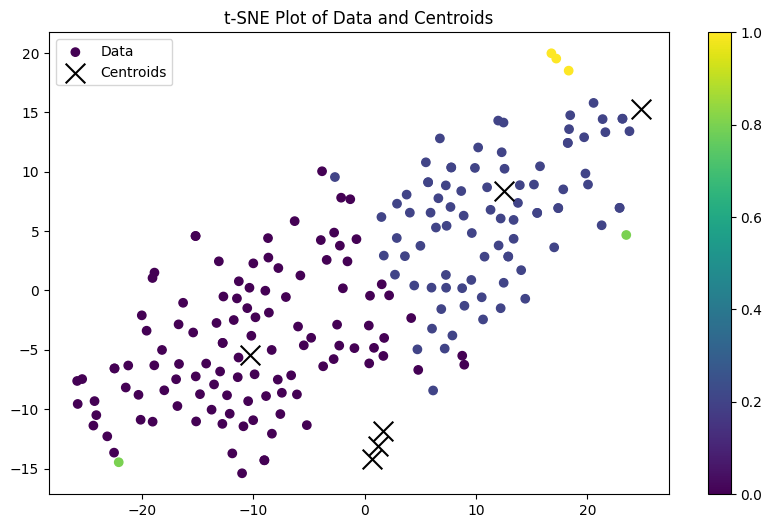

Processing:  40%|████████████████████████████▍                                          | 8/20 [00:10<00:14,  1.24s/it]

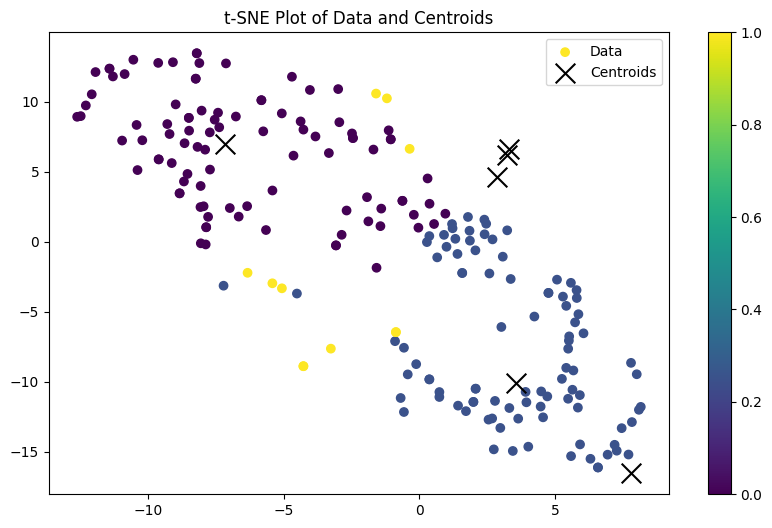

Processing:  45%|███████████████████████████████▉                                       | 9/20 [00:11<00:13,  1.26s/it]

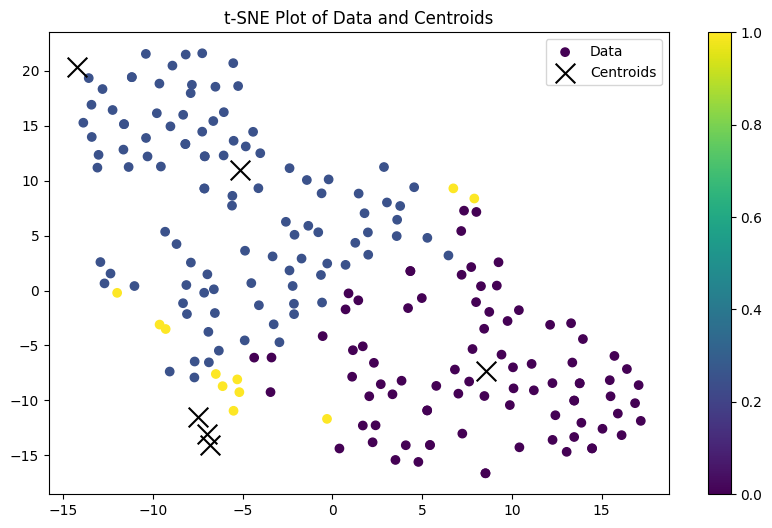

Processing:  50%|███████████████████████████████████                                   | 10/20 [00:13<00:13,  1.36s/it]

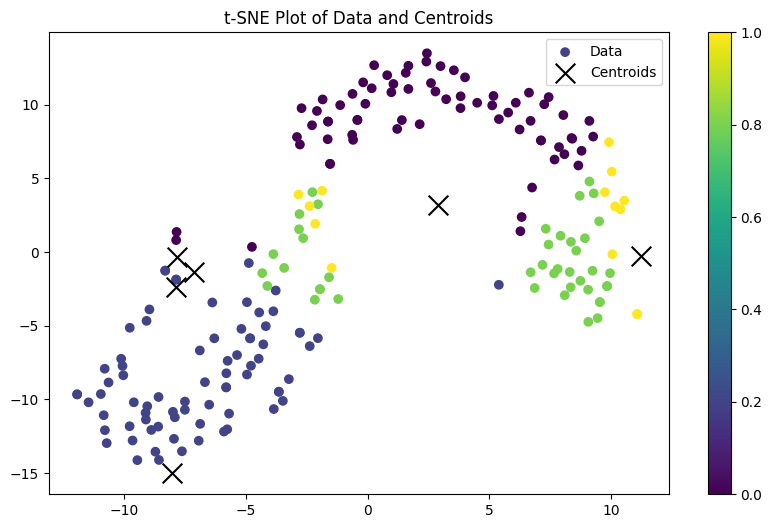

Processing:  55%|██████████████████████████████████████▌                               | 11/20 [00:14<00:12,  1.40s/it]

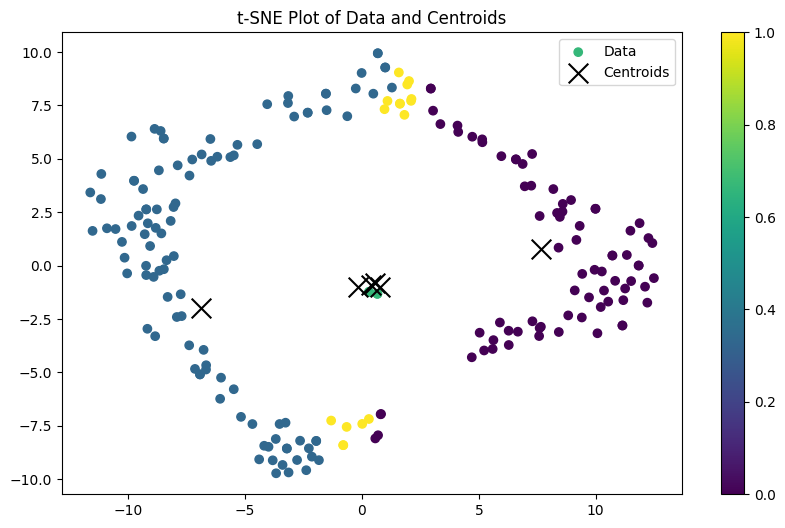

Processing:  60%|██████████████████████████████████████████                            | 12/20 [00:16<00:11,  1.38s/it]

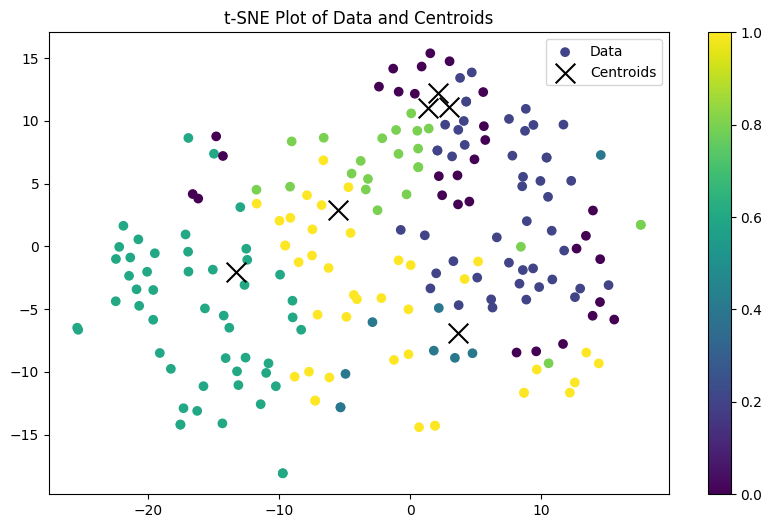

Processing:  65%|█████████████████████████████████████████████▌                        | 13/20 [00:17<00:09,  1.39s/it]

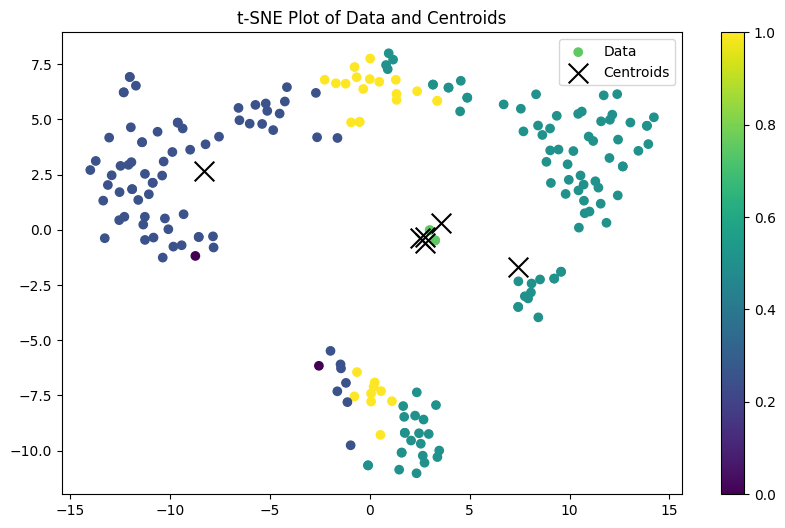

Processing:  70%|█████████████████████████████████████████████████                     | 14/20 [00:18<00:08,  1.34s/it]

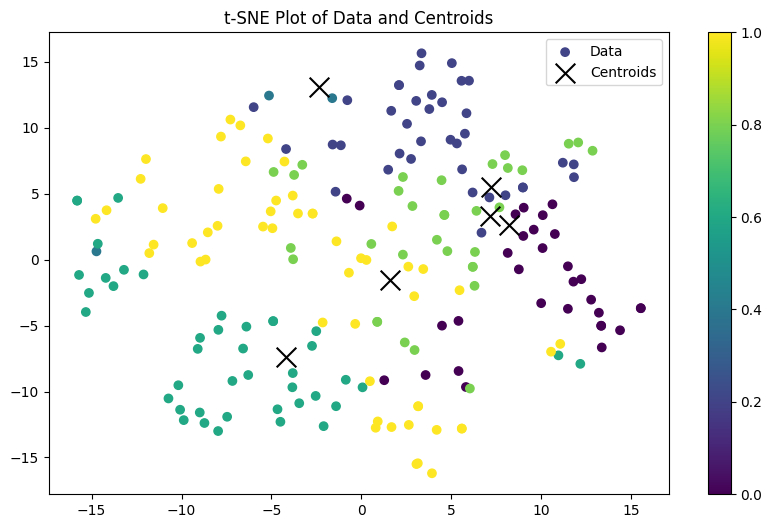

Processing:  75%|████████████████████████████████████████████████████▌                 | 15/20 [00:20<00:06,  1.33s/it]

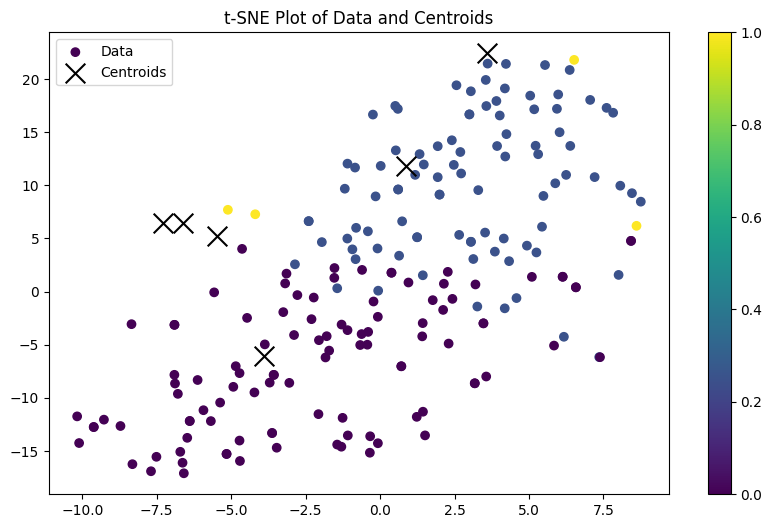

Processing:  80%|████████████████████████████████████████████████████████              | 16/20 [00:21<00:05,  1.37s/it]

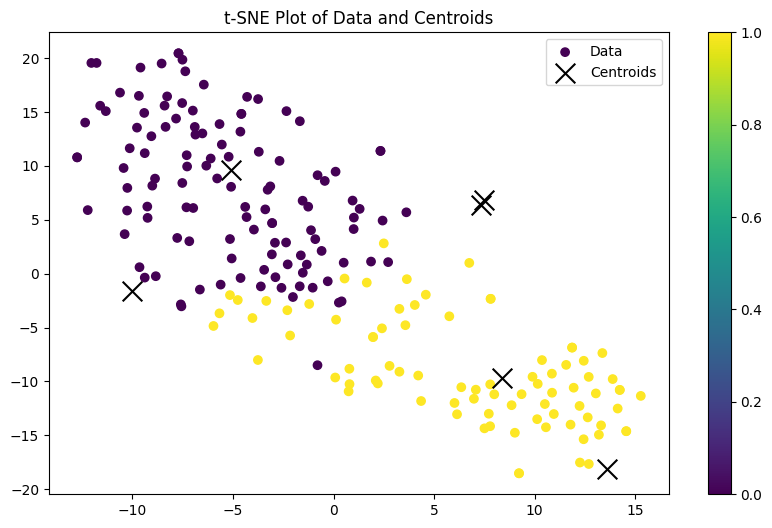

Processing:  85%|███████████████████████████████████████████████████████████▌          | 17/20 [00:23<00:04,  1.48s/it]

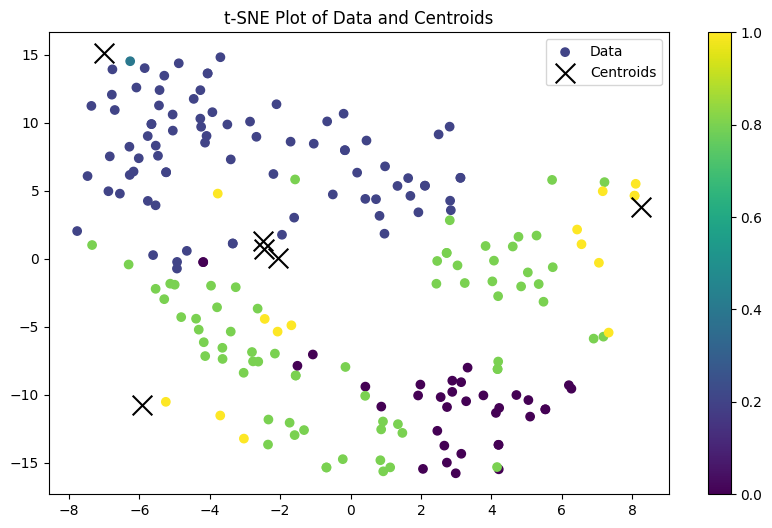

Processing:  90%|███████████████████████████████████████████████████████████████       | 18/20 [00:24<00:02,  1.40s/it]

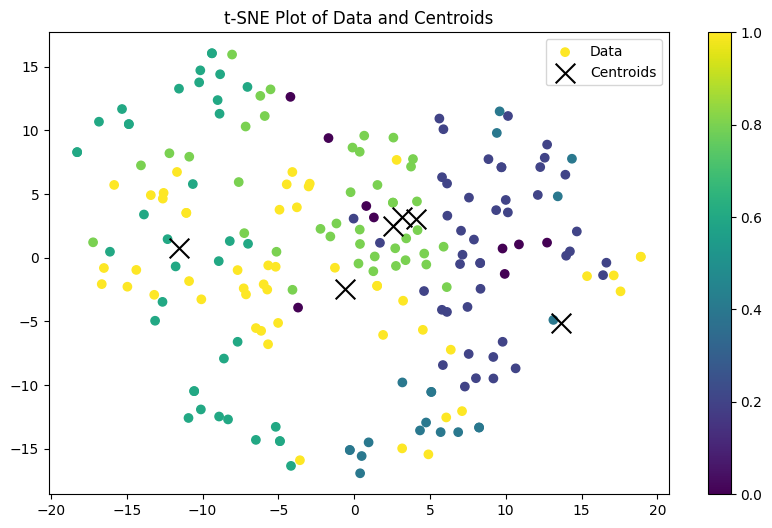

Processing:  95%|██████████████████████████████████████████████████████████████████▌   | 19/20 [00:25<00:01,  1.40s/it]

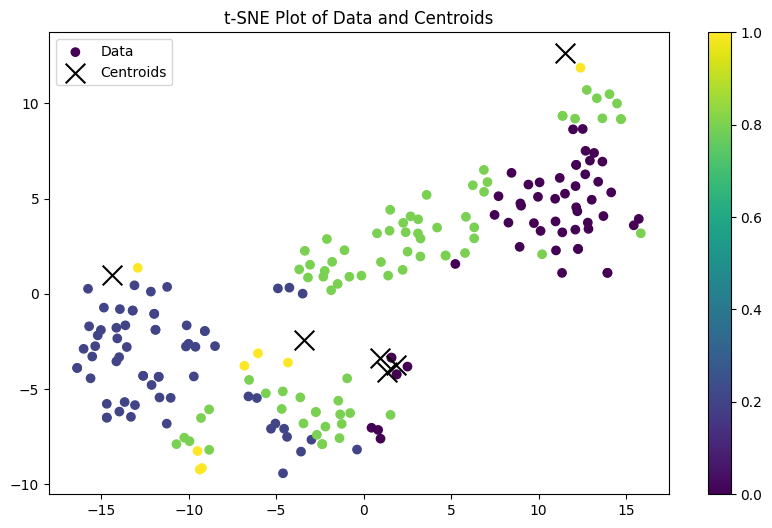

Processing: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


In [ ]:
diagnosis_chunk, diagnosis_iterations, best_centroids = train_incremental_local_fuzzy_cmeans(n_clusters, chunks, chunks_y, chunks_test, chunks_test_y, visualise_data=True, plot_func=plot_tsne, clusters_for_each_class=clusters_for_each_class.copy(), init_centroids=init_centroids.copy())

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie IFCM

In [ ]:
diagnosis_chunk, diagnosis_iterations, best_centroids = train_incremental_fuzzy_cmeans(n_clusters, chunks_shuffled, chunks_test, chunks_test_y, visualise_data=True, plot_func=plot_tsne, init_centroids=init_centroids_shuffled.copy())

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie z rozszerzającymi się danymi IFCM

In [ ]:
diagnosis_chunk, diagnosis_iterations, best_centroids = train_incremental_fuzzy_cmeans_extending_data(n_clusters, chunks_shuffled, chunks_test, chunks_test_y, visualise_data=True, init_centroids=init_centroids_shuffled.copy())

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Badania zachowania się metody ze względu na liczbę clustrów



In [ ]:
def find_optimal_number_of_clusters_ifcm(range_ = range(2,10)):
    output_data_chunk = []
    output_data_iter = []
    for n in range_:
        print('Rozważam: ', n)
        diagnosis_tools, diagnosis_iterations = train_incremental_fuzzy_cmeans(n, chunks, chunks_test, chunks_test_y)
        output_data_chunk.append(diagnosis_tools)
        output_data_iter.append(diagnosis_iterations)
    plot_statistic = DiagnosisTools()

    for n in range_:
        sil, dave, fpc, rand = output_data_chunk[n-2].get_avg()
        plot_statistic.add_elements(sil, dave, fpc, rand)

    plot_statistic.plot_lists()

    return plot_statistic, output_data_chunk, output_data_iter

#find_optimal_number_of_clusters_ifcm()

# Testowanie algorytmu ISSFCM

In [ ]:
from libraries.FCM.ISSFCM import incremental_semi_supervised_fuzzy_cmeans
from libraries.FCM.ISSFCM import train_incremental_semi_supervised_fuzzy_cmeans, train_local_incremental_semi_supervised_fuzzy_cmeans

### Trenowanie ISSFCM

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.04561369625935244
Davies-Bouldin Score: 1.8191133150150343
Rand Score: 0.681864591147787
Tested fpc: 0.38932414963191525
Accuracy: 0.7125
Precision:  0.544631093544137
Recall:  0.7125
4


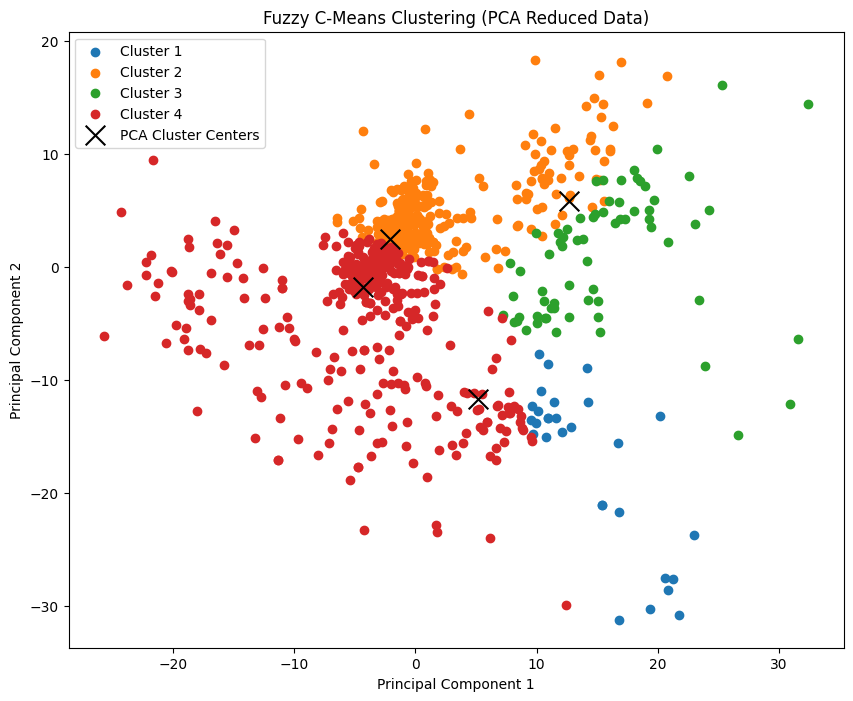

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.3781033314346835
Davies-Bouldin Score: 1.1648274180315787
Rand Score: 0.6409283570892723
Tested fpc: 0.5922997662008563
Accuracy: 0.5
Precision:  0.3333333333333333
Recall:  0.5
Rozważamy obecnie chunk numer:  0
Liczba klastrów:  4


Processing:  25%|█████████▎                           | 1/4 [00:00<?, ?it/s]

4


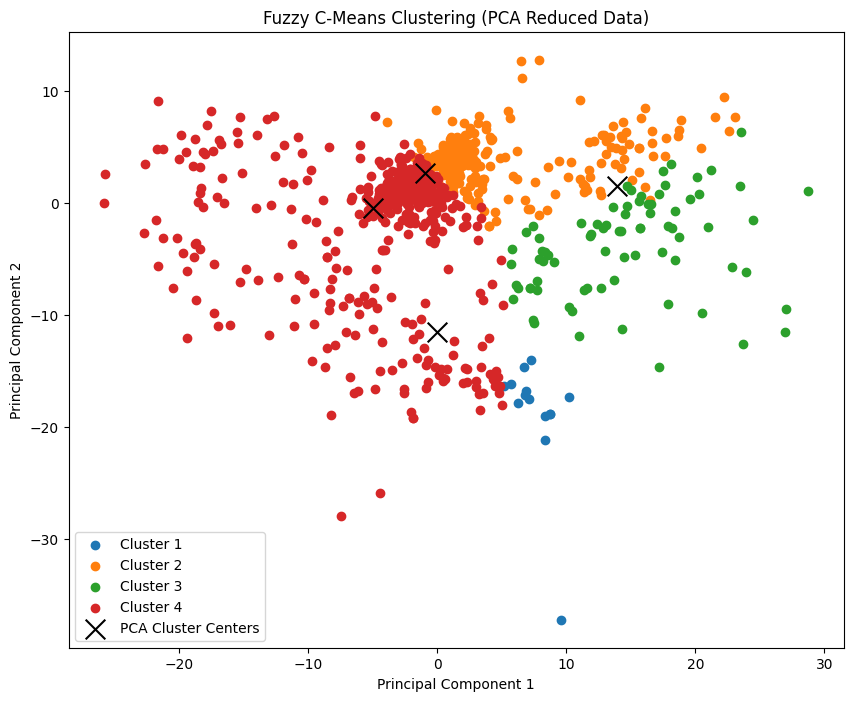

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.38855374217919975
Davies-Bouldin Score: 1.159953192535334
Rand Score: 0.6382429357339335
Tested fpc: 0.5922170972264921
Accuracy: 0.5
Precision:  0.3333333333333333
Recall:  0.5
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  4


Processing:  50%|██████████████████▌                  | 2/4 [00:00<?, ?it/s]

4


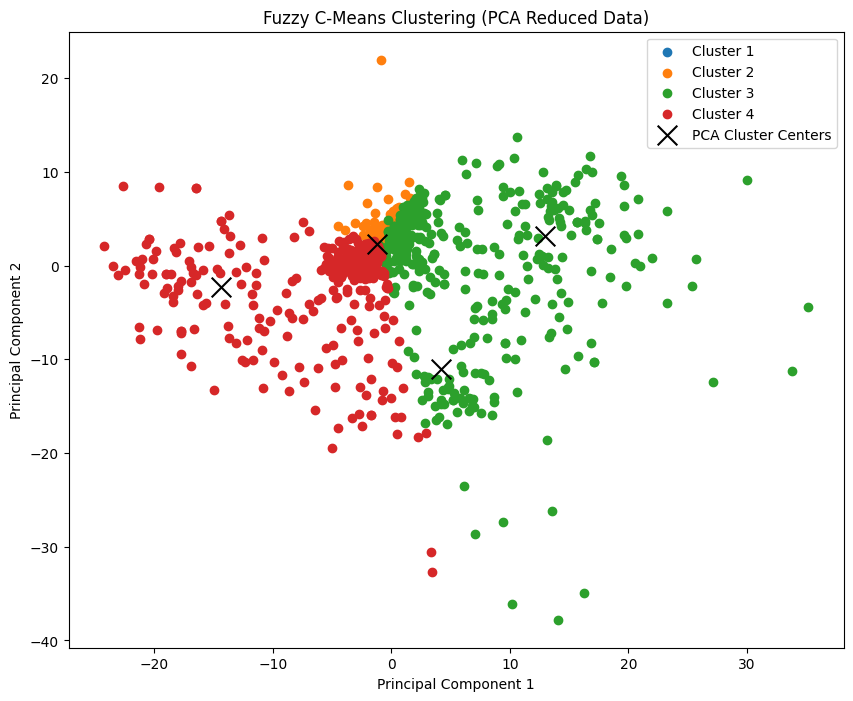

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.5488743169224607
Davies-Bouldin Score: 0.9906800486663837
Rand Score: 0.5987304326081521
Tested fpc: 0.6751813008289861
Accuracy: 0.5
Precision:  0.3333333333333333
Recall:  0.5
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  4


Processing:  75%|███████████████████████████▊         | 3/4 [00:00<?, ?it/s]


4


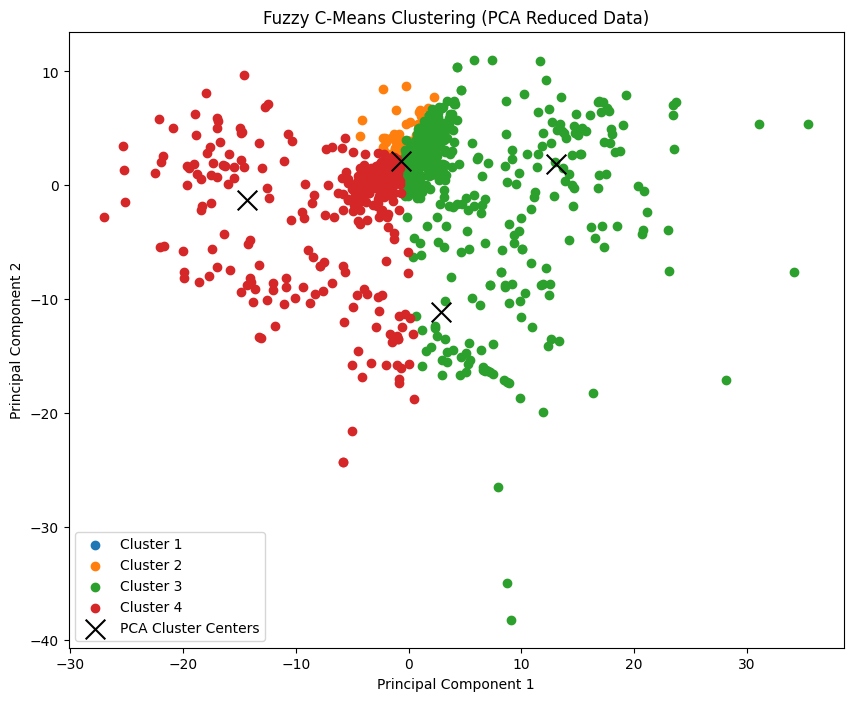

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.5484735934325411
Davies-Bouldin Score: 1.002529724050658
Rand Score: 0.6014194798699675
Tested fpc: 0.673063701909452
Accuracy: 0.5
Precision:  0.3333333333333333
Recall:  0.5
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  4


Processing: 100%|█████████████████████████████████████| 4/4 [00:00<?, ?it/s]

Czas wykonania: 2.378002166748047 sekund


In [60]:
diagnosis_chunk, diagnosis_iterations, best_centroids = train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks_shuffled, chunks_y_shuffled, chunks_y_matrix, chunks_test, chunks_test_y, m=m, visualise_data=True, init_centroids=init_centroids_shuffled.copy())

Historia danych ze względu na kolejne chunki


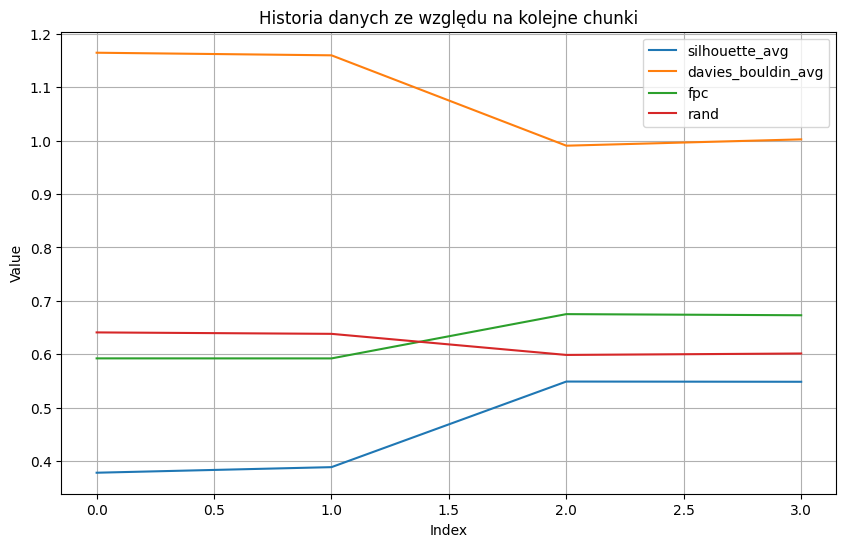

Historia statystyk ze względu na kolejne chunki


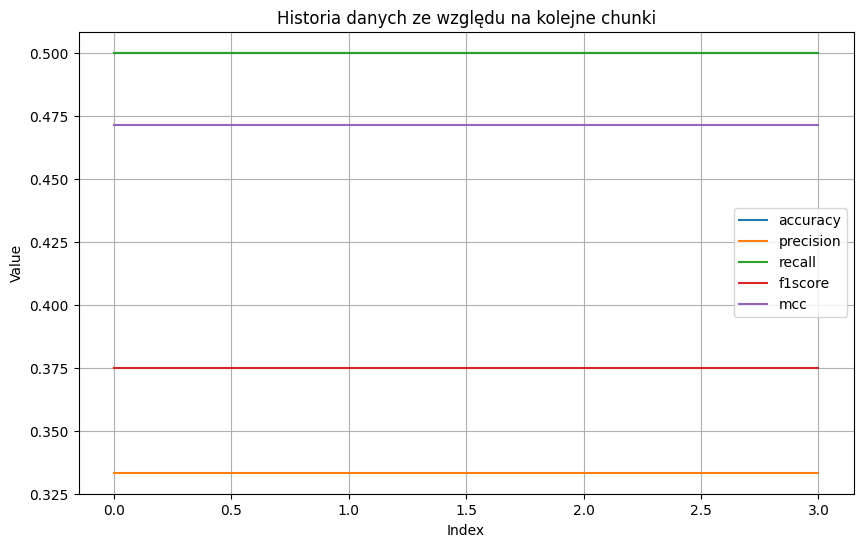

Historia danych wewnatrz iteracji dla pierwszego chunka


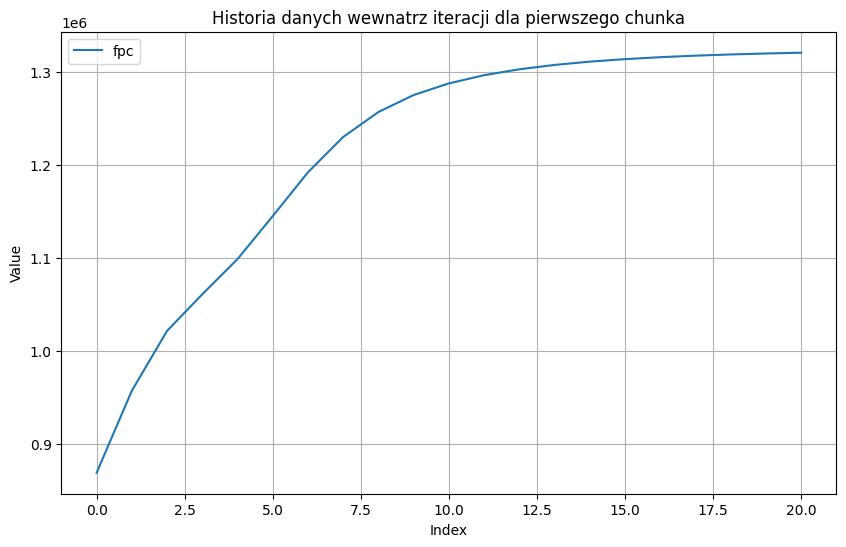

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


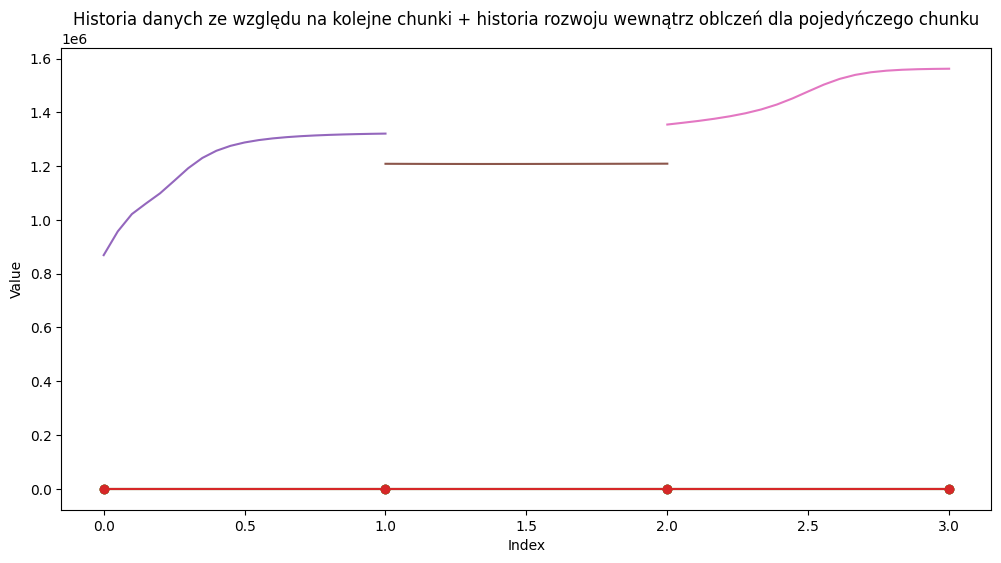

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


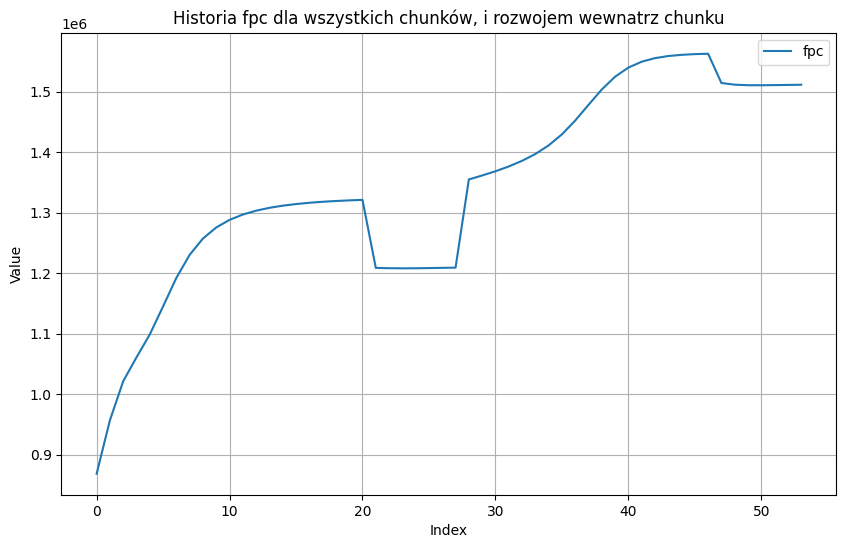

Historia centroidów ze względu na chunki


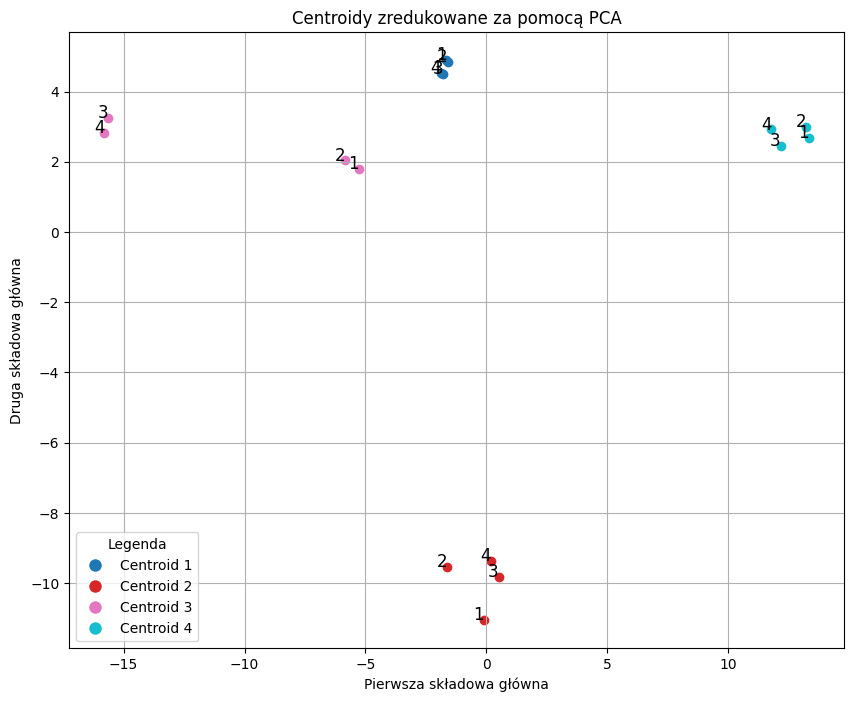

fpc last 0.673063701909452
rand last 0.6014194798699675


In [61]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie ISSFCM tylko wybranych centroidów

Silhouette Score: 0.07896857153254407
Davies-Bouldin Score: 1.6089276343568448
Rand Score: 0.6818363340835208
Tested fpc: 0.3904490773300519
Accuracy: 0.6875
Precision:  0.5400264394829613
Recall:  0.6875
4


C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


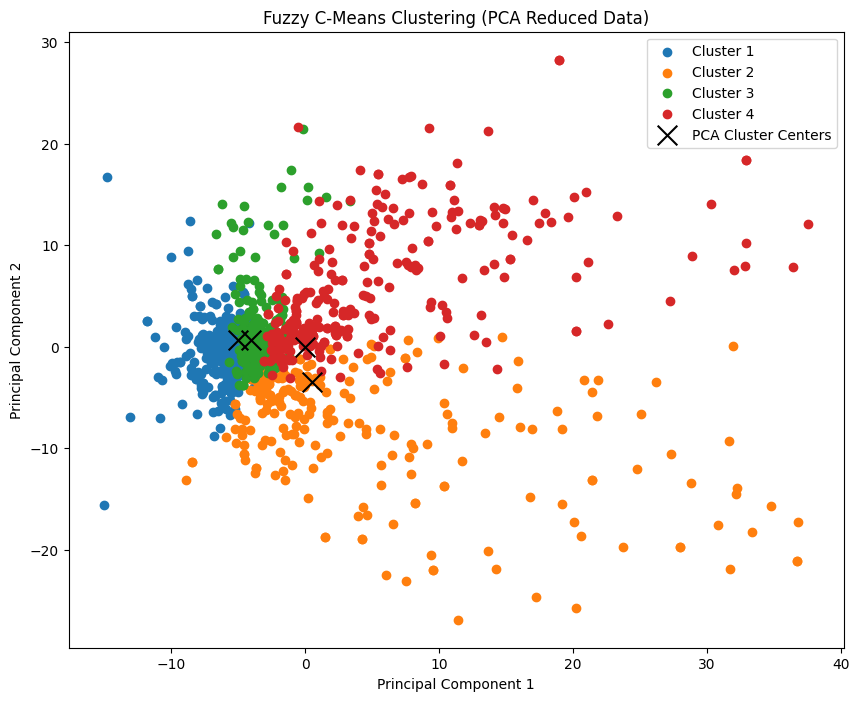

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.0804905470416606
Davies-Bouldin Score: 1.60583370949453
Rand Score: 0.6819722430607652
Tested fpc: 0.39004277723803066
Accuracy: 0.6875
Precision:  0.5400264394829613
Recall:  0.6875
Rozważamy obecnie chunk numer:  0
Liczba klastrów:  4


Processing:  25%|█████████▎                           | 1/4 [00:00<?, ?it/s]

4


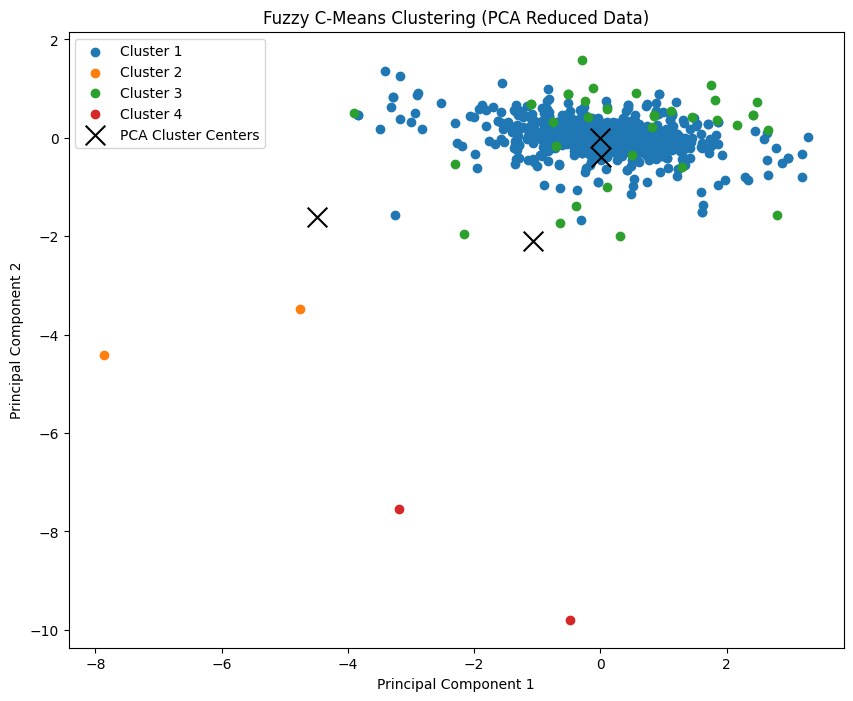

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.09066323822450235
Davies-Bouldin Score: 1.5728564458008183
Rand Score: 0.683437984496124
Tested fpc: 0.3950245346646973
Accuracy: 0.725
Precision:  0.5536413043478261
Recall:  0.725
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  4


Processing:  50%|██████████████████▌                  | 2/4 [00:00<?, ?it/s]

4


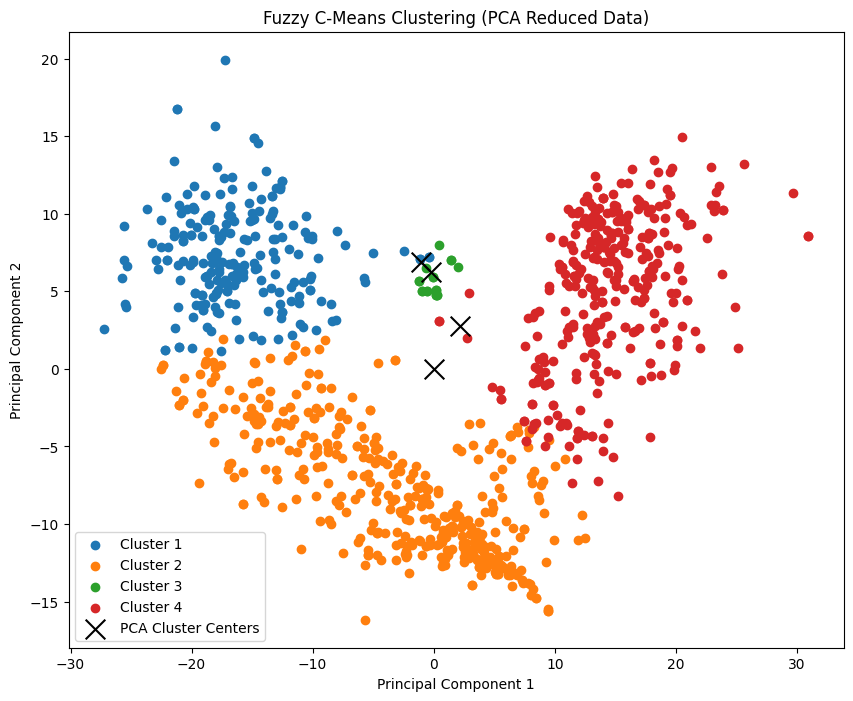

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.09063989956815979
Davies-Bouldin Score: 1.5720635611338585
Rand Score: 0.682941360340085
Tested fpc: 0.39497728826193024
Accuracy: 0.725
Precision:  0.5610119047619048
Recall:  0.725
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  4


Processing:  75%|███████████████████████████▊         | 3/4 [00:00<?, ?it/s]

4


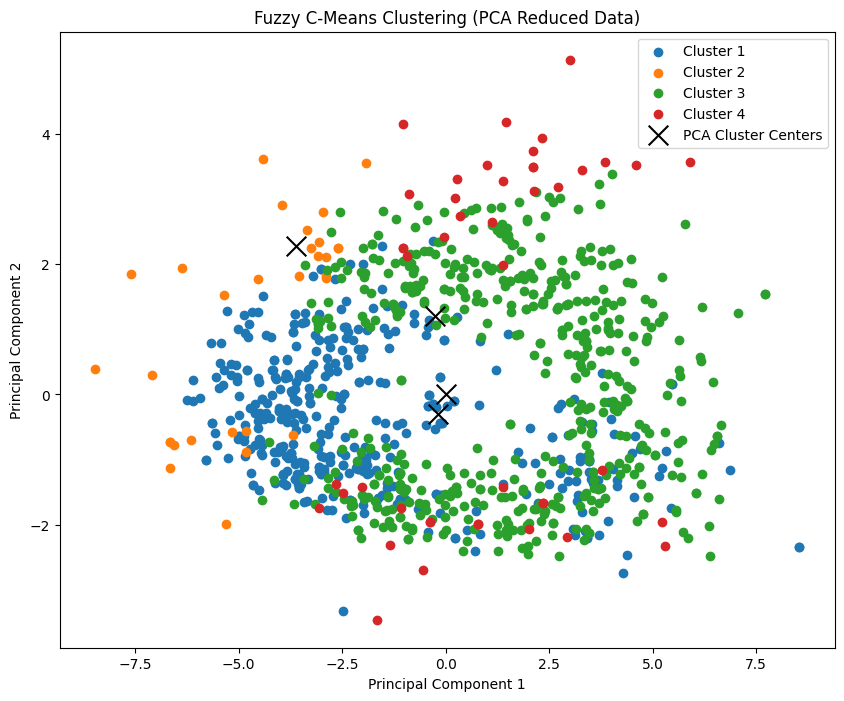

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.08802554686149336
Davies-Bouldin Score: 1.5622676371255058
Rand Score: 0.684006126531633
Tested fpc: 0.39192426980705614
Accuracy: 0.7375
Precision:  0.5644889757792984
Recall:  0.7375
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  4


Processing: 100%|█████████████████████████████████████| 4/4 [00:00<?, ?it/s]


4


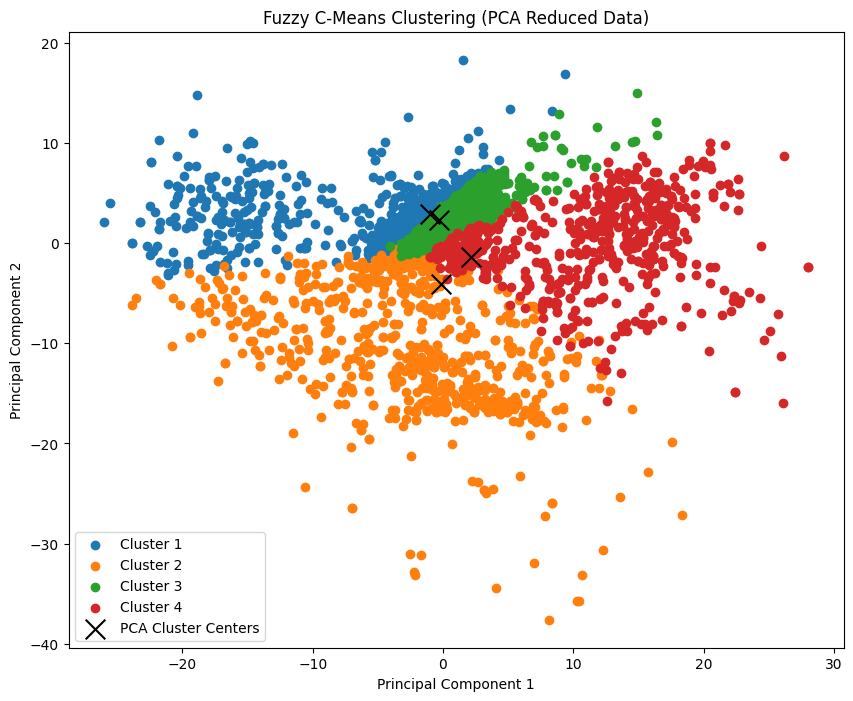

Cluster 0: counts = 1845, summed_labels = 1634.1146515123037, fcm per point 0.8856989981096497 
Cluster 1: counts = 727, summed_labels = 594.7310055587296, fcm per point 0.81806190585795 
Cluster 2: counts = 826, summed_labels = 1118.5563396307382, fcm per point 1.3541844305456878 
Cluster 3: counts = 602, summed_labels = 652.5980032982308, fcm per point 1.0840498393658318 
Czas wykonania: 2.378471851348877 sekund


In [62]:
diagnosis_chunk, diagnosis_iterations, best_centroids = train_local_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y, chunks_y_matrix, chunks_test, chunks_test_y, clusters_for_each_class.copy(), m=m, visualise_data=True, init_centroids=init_centroids.copy())

Historia danych ze względu na kolejne chunki


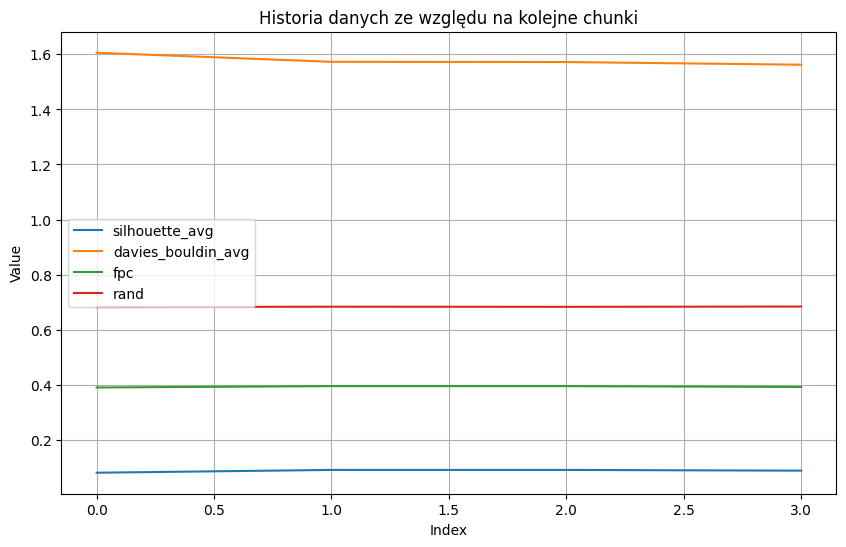

Historia statystyk ze względu na kolejne chunki


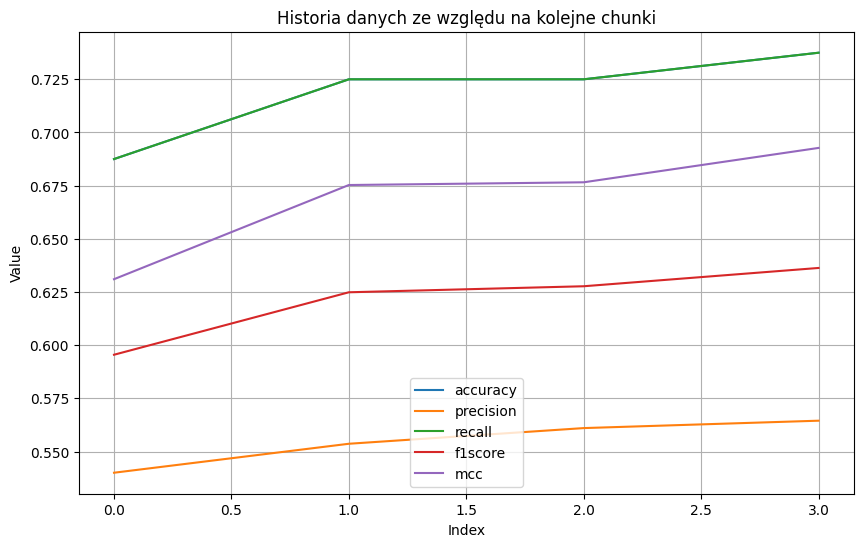

Historia danych wewnatrz iteracji dla pierwszego chunka


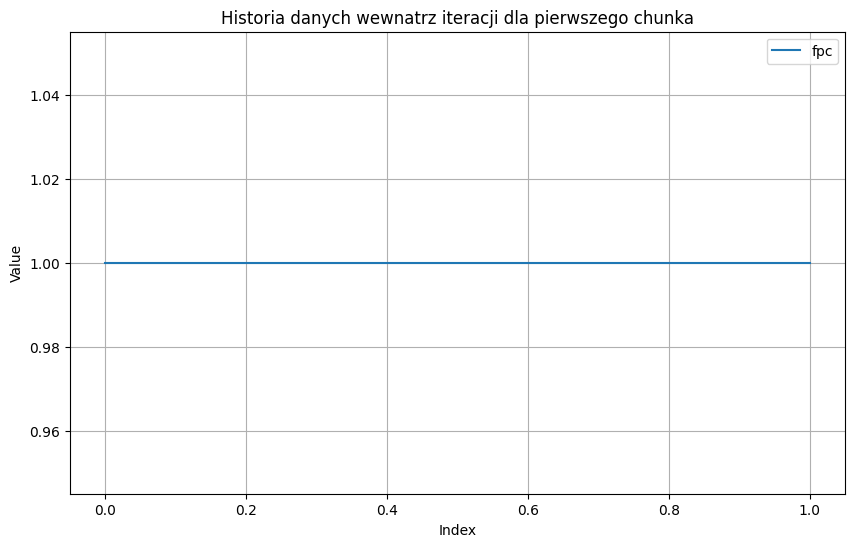

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


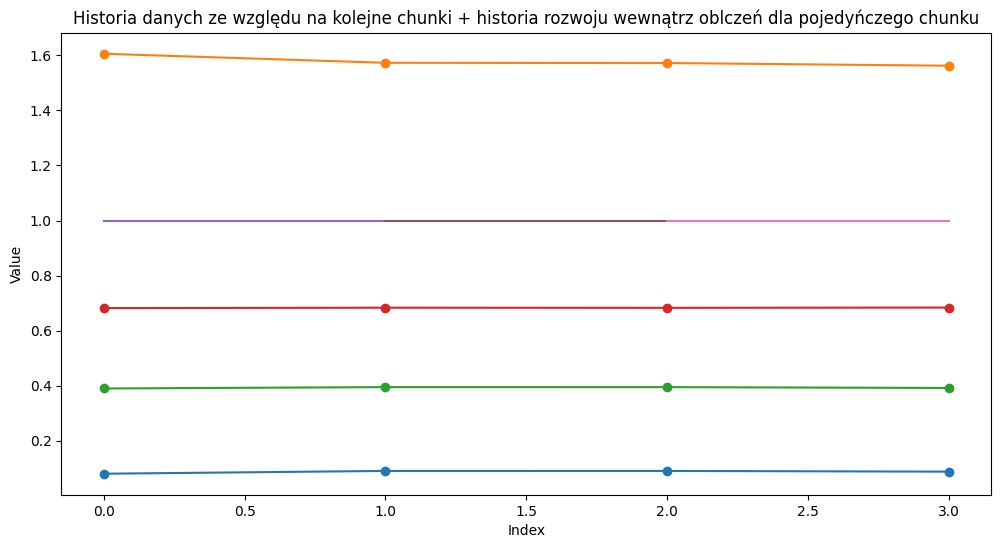

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


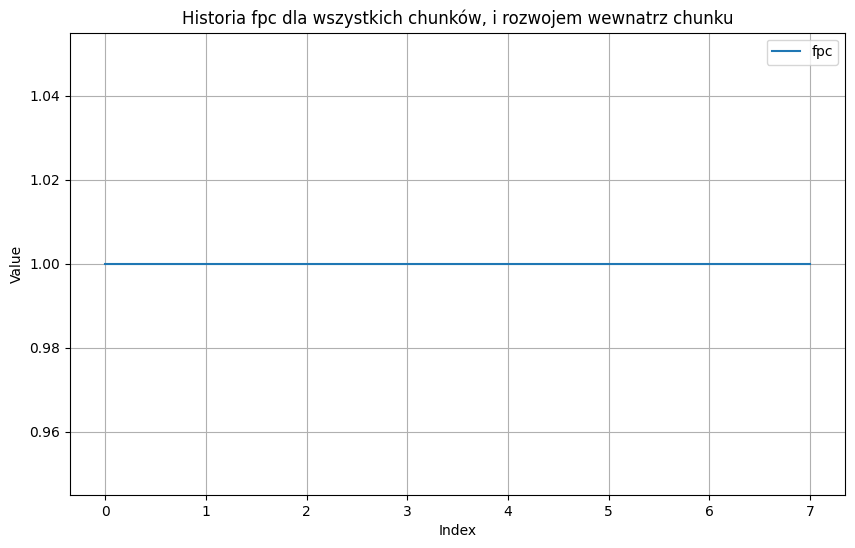

Historia centroidów ze względu na chunki


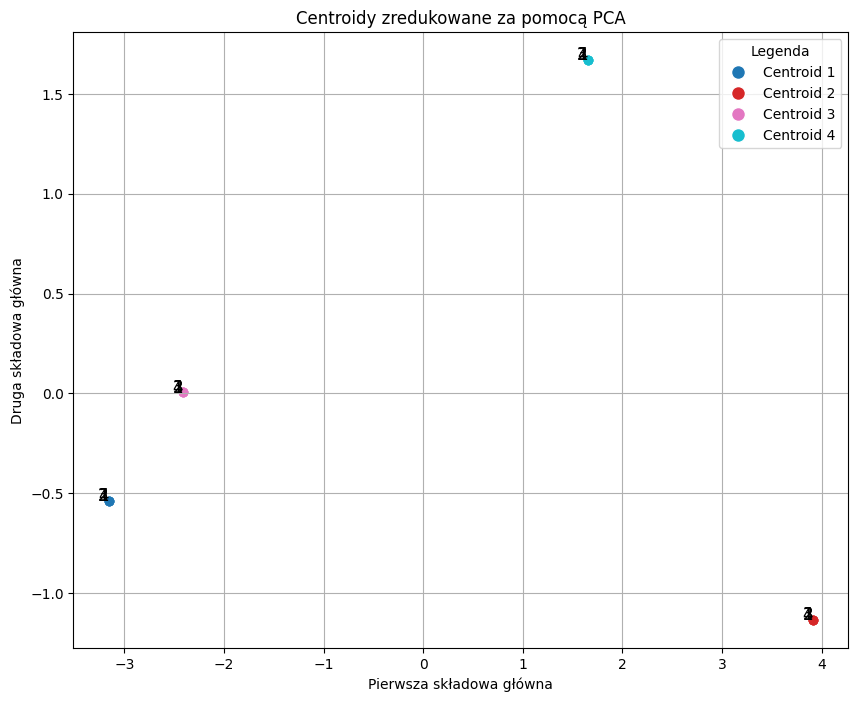

fpc last 0.39192426980705614
rand last 0.684006126531633


In [63]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

In [64]:
def find_optimal_number_of_clusters_issfcm(range_ = range(n_clusters,16)):
    output_data_chunk = []
    output_data_iter = []
    
    for n in range_:
        print('Rozważam: ', n)
        y_train_matrix, init_centroids = create_semi_supervised_matrix(X_train, y_train, n)
        _, _, chunks_y_matrix = create_dataset_chunks(chunk_train_sizes, X_train, y_train, y_train_matrix)
        diagnosis_tools, diagnosis_iterations = train_incremental_semi_supervised_fuzzy_cmeans(n, chunks, chunks_y_matrix, chunks_test, chunks_test_y, init_centroids=init_centroids)
        output_data_chunk.append(diagnosis_tools)
        output_data_iter.append(diagnosis_iterations)
    
    plot_statistic = DiagnosisTools()
    
    for n in range_:
        sil, dave, fpc, rand = output_data_chunk[n-n_clusters].get_avg()
        plot_statistic.add_elements(sil, dave, fpc, rand)
        
    plot_statistic.plot_lists()

    return plot_statistics

In [65]:
#find_optimal_number_of_clusters_issfcm()